# Install Environment using

```conda env create -f pipeline_env.yml```

```conda activate dphpc```

In [12]:
import os
import typing
import re
from glob import glob
import numpy as np  # <--
import datetime
from tqdm.notebook import tqdm # <--
import matplotlib.pyplot as plt # <--
import matplotlib.ticker as mticker

In [13]:
import pandas as pd # <--
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 220)

In [14]:
import seaborn as sns # <--
sns.set_style("darkgrid")
sns.set_context("poster")

In [15]:
def load_usage_info(logfile):
    if not logfile:
      return

    usage_info_starts_at = 0

    with open(logfile, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if "Resource usage summary" in line:
                usage_info_starts_at = linenumber
                break 
            if linenumber > 35:
                return

    usage_info = pd.read_csv(logfile, sep="\s+:\s+", skiprows=usage_info_starts_at+2, nrows=10, header=None, skipinitialspace=True).transpose()
    usage_info = usage_info.rename(columns=usage_info.iloc[0]).drop(0).reset_index(drop=True)
    usage_info["logfile"] = logfile
    
    return usage_info

In [16]:
def load_cpu_info(cpufile):
    if not cpufile:
      return

    cpu_info = pd.read_csv(cpufile, sep=":\s+", header=None).transpose()
    cpu_info = cpu_info.rename(columns=cpu_info.iloc[0]).drop(0).reset_index(drop=True)
    cpu_info["cpufile"] = cpufile

    return cpu_info

In [17]:
def load_lsb_data(datafile):
   if not datafile:
      return
   
   lsb_data = pd.read_csv(datafile, comment='#', sep='\s+')
   lsb_data["datafile"] = datafile

   if "size" not in lsb_data.columns:
      print(f"convert {datafile}")
      lsb_data["size"] = lsb_data["size_m"].astype(int) # TODO: Dirty hack

   return lsb_data

In [18]:
def load_cg_data(datafile):
    if not datafile:
      return

    kernel_info_starts_at = -1
    with open(datafile, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if "fn=kernel_" in line:
                kernel_info_starts_at = linenumber
                break 

    if kernel_info_starts_at < 0:
      return
    
    chache_data = pd.read_csv(datafile, sep="\s+", skiprows=kernel_info_starts_at, nrows=1, index_col=None, header=0, skipinitialspace=True, names=["Ir", "I1mr", "ILmr", "Dr", "D1mr", "DLmr", "Dw", "D1mw", "DLmw", "unknown"])
    chache_data["datafile"] = datafile
    return chache_data
    

In [19]:

# print(load_cg_data("./2021-11-23_20-04-51-cholesky_mpi_ll_naive/P4-D11/cachegrind.out.13960"))

# Ir    I1mr        ILmr    Dr  D1mr        DLmr        Dw      D1mw        DLmw 
# 0     2192211505  29      25  724913090   47623304    397786  365606246   1655786 616107


In [20]:
def load_experiment(datafile: str) -> typing.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    close_tag = sum("# Runtime" in line for line in open(datafile))
    if not close_tag:
        print(f"Skip {datafile} because file too short")
        return
    
    experiment_path = os.path.dirname(datafile)

    cpufile = glob(experiment_path+"/CPU*")
    logfile = glob(experiment_path+"/job*")
    #errorfile = glob(experiment_path+"/error*")

    if not cpufile or not logfile:
        print(f"Skip {datafile} because cpu/log file not found")
        return

    cpufile = cpufile[0]
    cpufile_num_lines = sum(1 for line in open(cpufile))
    if cpufile_num_lines < 26:
        print(f"Skip {datafile} because cpu file too short")
        return
    
    logfile = logfile[0]
    logfile_num_lines = sum(1 for line in open(logfile))
    if logfile_num_lines < 34:
        print(f"Skip {datafile} because log file too short")
        return
    
    experiment_date = experiment_path[2:21]
    experiment_binary, experiment_params = experiment_path[22:].split("/")
    experiment_processes, experiment_dim = experiment_params.split("-")
    
    experiment = pd.DataFrame({
        "date" : datetime.datetime.strptime(experiment_date, '%Y-%m-%d_%H-%M-%S'),
        "binary" : experiment_binary,
        "p" : int(experiment_processes[1:]), 
        "d" : int(experiment_dim[1:]),
        #"m" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        #"n" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        "datafile" : datafile,
        "cpufile" : cpufile,
        "logfile" : logfile, 
        #"errorfile" : errorfile,
    }, index=[0])
   
    return experiment


In [21]:
# Collect data from all experiments

experiments=pd.DataFrame()
libscibenchdata=pd.DataFrame()
cachegrinddata=pd.DataFrame()
usage_info=pd.DataFrame()
cpu_info=pd.DataFrame()

print("Load libscibench data")
for libscibench in tqdm(glob("./2021*/P*D*/lsb*"), unit='Files'):
    experiment = load_experiment(libscibench)
    if experiment is None:
        continue

    experiments = experiments.append(experiment)
    libscibenchdata = libscibenchdata.append(load_lsb_data(experiment["datafile"][0]))

libscibenchdata = libscibenchdata.reset_index(drop=True)

print("\nLoad cachegrind data")
for cachegrind in tqdm(glob("./2021*/P*D*/cachegrind*"), unit='Files'):
    experiment = load_experiment(cachegrind)
    if experiment is None:
        continue
    
    experiments = experiments.append(experiment)
    cachegrinddata = cachegrinddata.append(load_cg_data(experiment["datafile"][0]))

cachegrinddata = cachegrinddata.reset_index(drop=True)


experiments = experiments.reset_index(drop=True)

print("\nLoad usage data")
usage_info = usage_info.append([load_usage_info(logfile) for logfile in tqdm(experiments["logfile"].unique(), unit='Files')])
usage_info = usage_info.drop_duplicates().reset_index(drop=True)

print("\nLoad cpu data")
cpu_info = cpu_info.append([load_cpu_info(cpufile) for cpufile in tqdm(experiments["cpufile"].unique(), unit='Files')])
cpu_info = cpu_info.drop_duplicates().reset_index(drop=True)

Load libscibench data


  0%|          | 0/1187 [00:00<?, ?Files/s]

Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P2-D13/lsb.parallel_gramschmidt.8192x8192_1.r0 because file too short
Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P2-D13/lsb.parallel_gramschmidt.8192x8192_0.r0 because file too short
convert ./2021-11-25_00-14-30-parallel_gramschmidt/P2-D5/lsb.parallel_gramschmidt.32x32_1.r0
convert ./2021-11-25_00-14-30-parallel_gramschmidt/P2-D5/lsb.parallel_gramschmidt.32x32_0.r0
Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P4-D13/lsb.parallel_gramschmidt.8192x8192_3.r0 because file too short
Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P4-D13/lsb.parallel_gramschmidt.8192x8192_2.r0 because file too short
Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P4-D13/lsb.parallel_gramschmidt.8192x8192_1.r0 because file too short
Skip ./2021-11-25_00-14-30-parallel_gramschmidt/P4-D13/lsb.parallel_gramschmidt.8192x8192_0.r0 because file too short
convert ./2021-11-25_00-14-30-parallel_gramschmidt/P16-D11/lsb.parallel_gramschmidt.2048x2048_5.r0
convert

0Files [00:00, ?Files/s]


Load usage data


  0%|          | 0/95 [00:00<?, ?Files/s]


Load cpu data


  0%|          | 0/95 [00:00<?, ?Files/s]

In [22]:
print("Experiments:")
print(experiments.head(2))
print("\nlibscibenchdata:")
print(libscibenchdata.head(2))
print("\cachegrinddata:")
print(cachegrinddata.head(2))
print("\nUsage_info:")
print(usage_info.head(2))
print("\nCpu_info:")
print(cpu_info.head(2))


Experiments:
                 date                binary  p  d                       datafile                        cpufile                        logfile
0 2021-11-25 00:14:30  parallel_gramschmidt  2  5  ./2021-11-25_00-14-30-para...  ./2021-11-25_00-14-30-para...  ./2021-11-25_00-14-30-para...
1 2021-11-25 00:14:30  parallel_gramschmidt  2  5  ./2021-11-25_00-14-30-para...  ./2021-11-25_00-14-30-para...  ./2021-11-25_00-14-30-para...

libscibenchdata:
   rank  size_m  size_n       region type  id       time  overhead                       datafile  size
0   1.0      32      32  gramschmidt  MPI   0  93.968750         0  ./2021-11-25_00-14-30-para...    32
1   1.0      32      32  gramschmidt  MPI   1  73.870117         0  ./2021-11-25_00-14-30-para...    32
\cachegrinddata:
Empty DataFrame
Columns: []
Index: []

Usage_info:
        CPU time Max Memory Average Memory Total Requested Memory Delta Memory Max Swap Max Processes Max Threads  Run time Turnaround time                     

In [23]:
# Graph Globals

BASELINE = ["classical", "gramschmidt"]
PARALLEL = ["classical_mpi", "parallel_gramschmidt"]

ORDER = BASELINE + PARALLEL # ["classical", "gramschmidt", "modified", "classical_mpi", "gramschmidt_mpi", "parallel_gramschmidt"]
print(ORDER)
WRAP = 2

['classical', 'gramschmidt', 'classical_mpi', 'parallel_gramschmidt']


/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


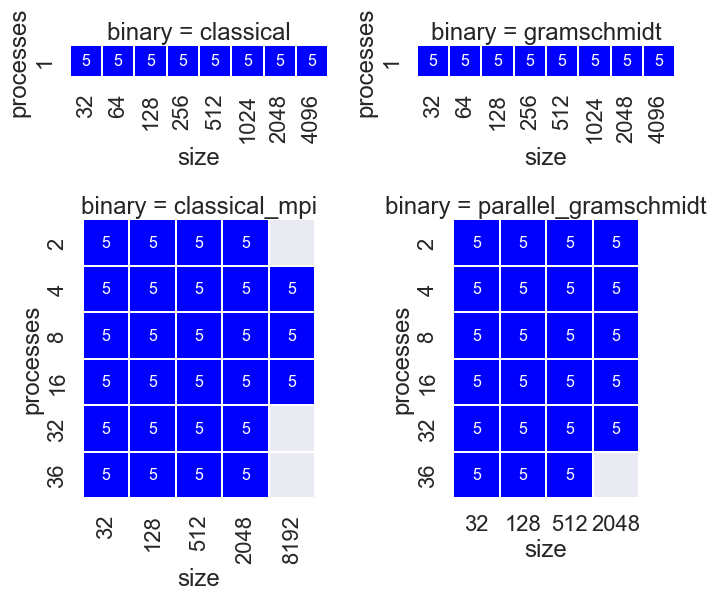

In [24]:
# Data Coverage

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = pd.merge(data, cpu_info[["cpufile", "CPU max MHz"]], on="cpufile")
data = data[["binary", "date", "p", "size", "id", "rank", "time", "CPU max MHz"]]
data = data.groupby(["binary", "date", "p", "size", "id", "CPU max MHz"], as_index=False)["time"].max().reset_index(drop=True)
data = data.groupby(["binary", "date", "p", "size", "CPU max MHz"], as_index=False)["time"].count()
data = data[data["binary"].isin(ORDER)]


def facet(data, color):
    coverage = data.pivot(index="p", columns='size', values='time')
    f = sns.heatmap(coverage, cmap='winter', annot=True, cbar=False, square=True, linewidth=2, linecolor='w', annot_kws={'fontsize':16})
    f.set_ylabel("processes")
   

#g = sns.FacetGrid(data, col="binary", size=6, legend_out=True, sharex=False, sharey=False)
g = sns.FacetGrid(data, col="binary", size=5, legend_out=True, sharex=False, sharey=False, col_order=ORDER, col_wrap=WRAP)
yticks = np.sort(data["p"].unique())
xticks = np.sort(data["size"].unique())

g = g.map_dataframe(facet)

g.figure.savefig("./plots/data_coverage.png")


In [25]:
# Performance Plot

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = pd.merge(data, cpu_info[["cpufile", "CPU max MHz"]], on="cpufile")
data = data[["binary", "p", "size", "id", "rank", "time", "CPU max MHz"]]

data = data.groupby(["binary", "size", "p", "id", "CPU max MHz"], as_index=False)["time"].max().reset_index(drop=True)
data = data[data["binary"].isin(ORDER)]

print(data.head())

      binary  size  p  id CPU max MHz       time
0  classical    32  1   0   2701.0000  70.639648
1  classical    32  1   1   2701.0000  70.967773
2  classical    32  1   2   2701.0000  76.471680
3  classical    32  1   3   2701.0000  62.887695
4  classical    32  1   4   2701.0000  71.953125


/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


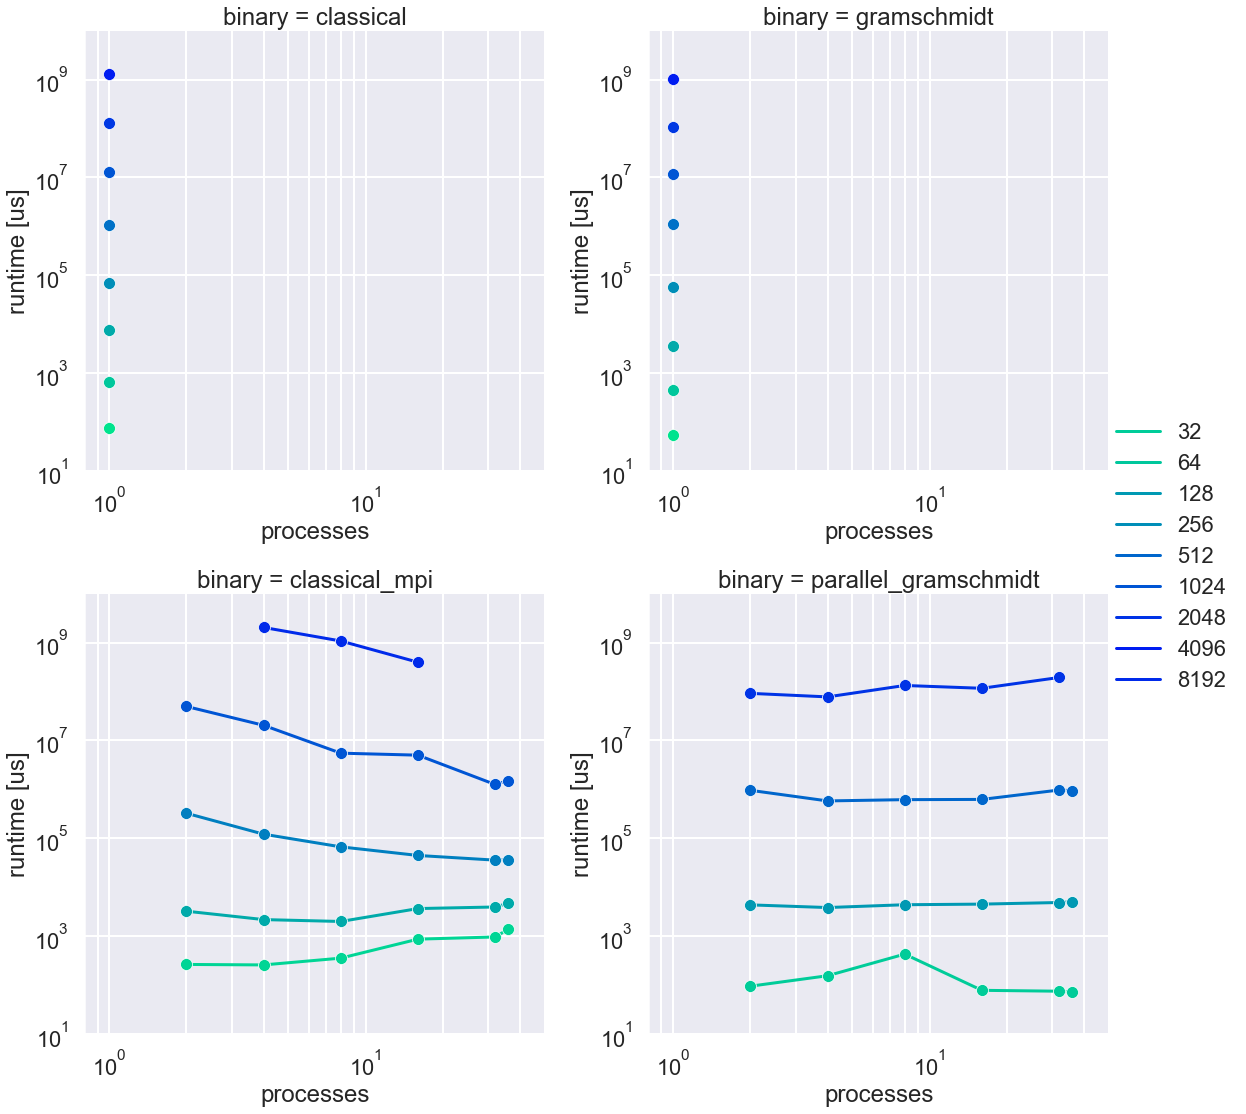

In [30]:
# Runtime per process

#data = data.sort_values(by=["size"])

def facet(data, color):
    n_colors = len(data["size"].unique())

    f = sns.lineplot(data=data, x="p", y="time", hue="size", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("processes")
    f.set_ylabel("runtime [us]")
    f.set(ylim=(10**1, 10**10)) 
    f.set(xlim=(0.8, 10**1.7)) 

    plt.grid(True,which="both")

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(data, col="binary", size=8, sharex=False, sharey=False, col_order=ORDER, col_wrap=WRAP)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/runtime_per_size.png")

/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


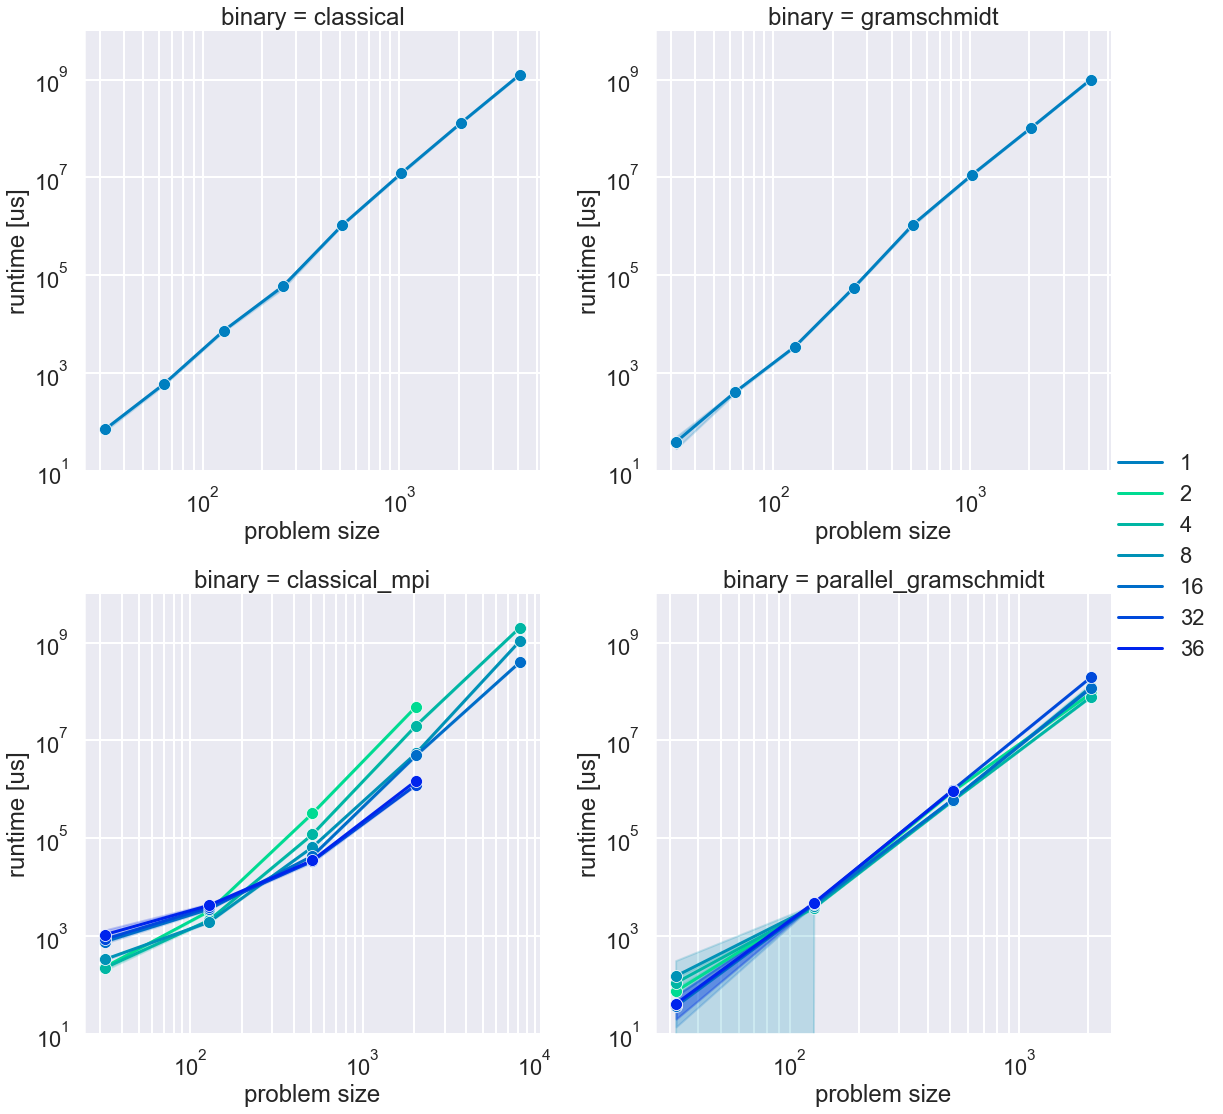

In [27]:
# Runtime as a function of problem size

data = data.sort_values(by=["p"])

def facet(data, color):
    n_colors = len(data["p"].unique())

    f = sns.lineplot(data=data, x="size", y="time", hue="p", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("problem size")
    f.set_ylabel("runtime [us]")
    f.set(ylim=(10**1, 10**10)) 

    plt.grid(True,which="both")

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(data, col="binary", size=8, sharex=False, sharey=False, col_order=ORDER, col_wrap=WRAP)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/runtime_per_process.png")


In [35]:
## Speed up

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = data[["binary", "p", "size", "id", "rank", "time"]]

data = data.groupby(["binary", "size", "p"], as_index=False)["time"].max()
#data["cycles"] = data["time"] * data["CPU max MHz"].astype('float')

#baseline = data["binary"].isin(BASELINE)

data["sequential_index"] = [BASELINE.index(element) if element in BASELINE else np.NaN for element in data["binary"]]
data["parallel_index"] = [PARALLEL.index(element) if element in PARALLEL else np.NaN for  element in data["binary"]]

print(data)

result = pd.merge(data[["size", "p", "time", "sequential_index"]].dropna(subset=['sequential_index'])
    , data[["binary", "size", "p", "time", "parallel_index"]].dropna(subset=['parallel_index'])
    , how='inner', left_on=['size','sequential_index'], right_on = ['size','parallel_index'], suffixes=["_seq", "_par"])

#sequential = data[baseline]
#parallel = data[~baseline & data["size"].isin(sequential["size"])]
result["speedup"] = result["time_seq"] / result["time_par"]

print(result["binary"].unique())


                  binary  size   p          time  sequential_index  parallel_index
0              classical    32   1  7.647168e+01               0.0             NaN
1              classical    64   1  6.569912e+02               0.0             NaN
2              classical   128   1  7.491504e+03               0.0             NaN
3              classical   256   1  6.790436e+04               0.0             NaN
4              classical   512   1  1.048762e+06               0.0             NaN
..                   ...   ...  ..           ...               ...             ...
90  parallel_gramschmidt  2048   2  9.152689e+07               NaN             1.0
91  parallel_gramschmidt  2048   4  7.749489e+07               NaN             1.0
92  parallel_gramschmidt  2048   8  1.326808e+08               NaN             1.0
93  parallel_gramschmidt  2048  16  1.162015e+08               NaN             1.0
94  parallel_gramschmidt  2048  32  1.933081e+08               NaN             1.0

[95

/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


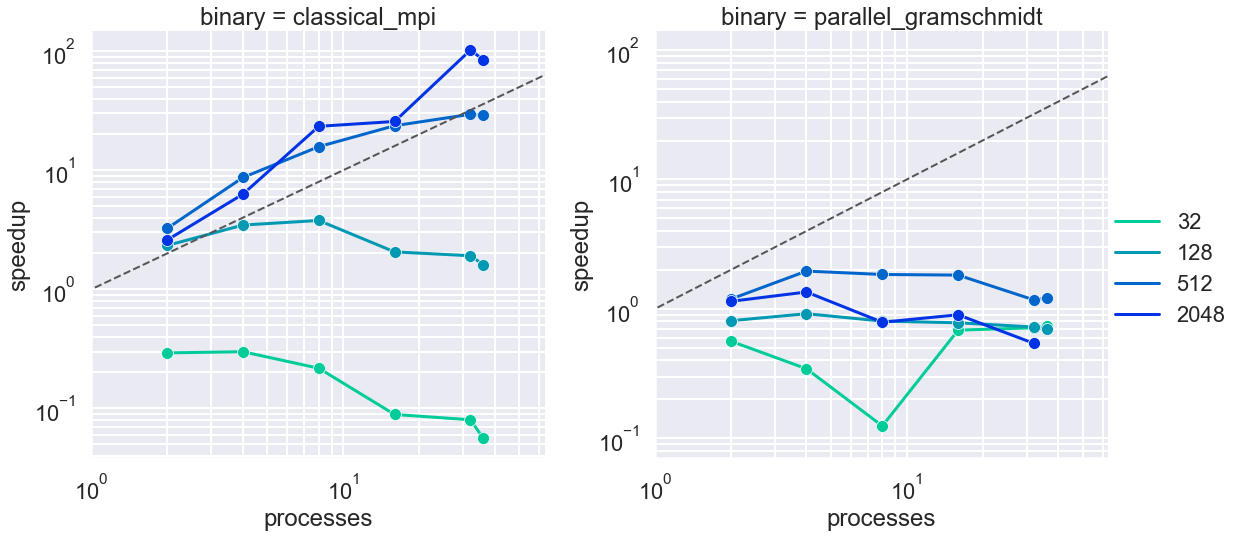

In [36]:
def facet(data, color):
      
    n_colors = len(data["size"].unique())

    f = sns.lineplot(data=data, x="p_par", y="speedup", hue="size", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("processes")
    f.set_ylabel("speedup")
    #f.set(ylim=(10**-2, 10**1.5)) 
    f.set(xlim=(10**0, 10**1.8)) 

    X_plot = np.logspace(-1, 2, 2)
    plt.grid(True,which="both")
    plt.plot(X_plot, X_plot, linewidth=2, color='#555555', linestyle='--')

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(result, col="binary", size=8, sharex=False, sharey=False)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/speedup_per_process.png")
